# Network component analysis

In [1]:
import pandas as pd
from pathlib import Path
import networkx as nx
from networkx.algorithms import community
from tqdm import tqdm
import copy
from time import perf_counter
import matplotlib.pyplot as plt
from dotenv import load_dotenv
load_dotenv("./.env.local")
import os
BEARER_TOKEN = os.getenv("BEARER_TOKEN")
import tweepy
client = tweepy.Client(BEARER_TOKEN, wait_on_rate_limit=True)

## Load the data and create NetworkX graphs

In [2]:
edgelists = {}
nx_graphs = {}

for file in Path("edgelistsFull").iterdir():
    tmp_edgelist = pd.read_csv(file)
    edgelists[file.stem] = tmp_edgelist

    tmp_nx_graph = nx.from_pandas_edgelist(tmp_edgelist, source='Source', target='Target', create_using=nx.Graph())
    # Ensure that graphs have a 'weight' edge attribute
    nx.set_edge_attributes(tmp_nx_graph, 1, 'weight')
    nx_graphs[file.stem] = tmp_nx_graph

## Our Louvain implementation

In [3]:
# Louvain implementation
def louvain(G, npassage):
    # Will contain the graph and the communities after each passage
    data = {}
    for i in range(0, npassage):
        print(f"Passage {i+1}", flush=True)
        G, communities, get_community = louvain_step(G, i==0)
        data[i] = get_community
        print(f"There are {len(communities)} communities after passage {i+1}", flush=True)
    return data


def louvain_step(G, is_first_passage):
    # Step 1: Initialization, start with each node being a single community
    communities = {idx: set([node]) for idx, node in enumerate(G.nodes)}
    # To get direct access to the community (it speeds up a bit the algorithm)
    get_community = {node: idx for idx, node in enumerate(G.nodes)}
    # Used in the modularity computation
    neighbors_sets = {node: set(G.neighbors(node)) for node in G.nodes}
    m = len(G.edges)

    # Sum the weights of the incident edges for all nodes inside a community, for all communities
    # Separate first passage and other ones to speed up the algorithm
    if is_first_passage:
        sum_communities = {idx: sum(dict(G.degree(community)).values()) for idx, community in communities.items()}
    else:
        sum_communities = {idx: sum(dict(G.degree(community, 'weight')).values()) for idx, community in communities.items()}

    prev_communities = {}
    i = 0
    # While there are changes in the communities, make another iteration
    while(communities != prev_communities):
        print(f"Iteration {i+1}", flush=True)
        # Deepcopy to have a new object with a new reference
        # Otherwise comparison in while is always True
        prev_communities = copy.deepcopy(communities)
        
        for node in tqdm(G.nodes):
            # Step 2: Remove node from its community
            neighboring_communities = get_neighboring_communities(G, node, get_community)
            if neighboring_communities == set():
                continue
            belong_to = get_community[node]
            communities[belong_to].remove(node)
            sum_communities[belong_to] -= G.degree(node, 'weight')
            if communities[belong_to] == set():
                del communities[belong_to]
                del sum_communities[belong_to]

            # Step 3: Insert the node in the community that maximizes the modularity
            scores = [
                (neighbor_community, modularity_gain(G, node, communities[neighbor_community], sum_communities[neighbor_community], neighbors_sets[node], m, is_first_passage))
                for neighbor_community in neighboring_communities
            ]
            best_community, best_score = max(scores, key=lambda x: x[1])
            communities[best_community].add(node)
            get_community[node] = best_community
            sum_communities[best_community] += G.degree(node, 'weight')
          
        i += 1

    # Step 4: Update the graph
    if is_first_passage:
        return get_new_graph(G, communities, sum_communities, get_community), communities, get_community
    return get_new_graph(G, communities, sum_communities, get_community), communities, get_community


def get_neighboring_communities(G, node, get_community):
    # Use a set to make sure a community only appear once
    neighboring_communities = set()
    for neighbor in G.neighbors(node):
        if neighbor == node: continue
        neighboring_communities.add(get_community[neighbor])
    return neighboring_communities


def modularity_gain(G, node, community, sum_community, neighbor_set, m, is_first_passage):
    # Separate first passage and other ones to speed up the algorithm
    if is_first_passage:
        # Sum the weights of the edges from node into community nodes
        # Using sets allow to use intersection()
        sum_weights_node = len(neighbor_set.intersection(community))
        right_member = (sum_community * G.degree[node]) / (2 * (m**2))
    else:
        # Sum the weights of the edges from node into community nodes
        sum_weights_node = sum([G.get_edge_data(node, member)['weight'] for member in G.neighbors(node) if member in community])
        right_member = (sum_community * G.degree(node, 'weight')) / (2 * (m**2))
    # Compute modularity
    left_member = sum_weights_node / (2 * m)
    return left_member - right_member


def get_new_graph(old_G, communities, sum_communities, get_community):
    print("Constructing new graph", flush=True)
    G = nx.Graph()
    G.add_nodes_from(communities.keys())
    for community in communities:
        G.add_edge(community, community, weight=sum_communities[community])

    for source, dest, weight_dict in old_G.edges(data=True):
        community1 = get_community[source]
        community2 = get_community[dest]
        # If edge not exist, weight initialized at 0
        current_weight = G.get_edge_data(community1, community2, {'weight': 0})['weight']
        new_weight = current_weight + weight_dict['weight']
        G.add_edge(community1, community2, weight=new_weight)
    return G

## Run our Louvain on the graphs

In [4]:
results = {}
for name, G in nx_graphs.items():
    print(f"Louvain on {name}")
    data = louvain(G, 2)
    results[name] = data
    print(f"\n")

Louvain on edgelists_any
Passage 1
Iteration 1


100%|█████████████████████████████████████████████████| 2790330/2790330 [00:26<00:00, 104329.51it/s]

Iteration 2



100%|█████████████████████████████████████████████████| 2790330/2790330 [00:24<00:00, 115729.28it/s]

Iteration 3



100%|█████████████████████████████████████████████████| 2790330/2790330 [00:24<00:00, 116181.67it/s]

Iteration 4



100%|█████████████████████████████████████████████████| 2790330/2790330 [00:24<00:00, 114486.42it/s]

Iteration 5



100%|█████████████████████████████████████████████████| 2790330/2790330 [00:24<00:00, 114833.16it/s]

Iteration 6



100%|█████████████████████████████████████████████████| 2790330/2790330 [00:24<00:00, 114803.17it/s]

Constructing new graph


There are 770 communities after passage 1
Passage 2
Iteration 1


100%|████████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 809.08it/s]

Iteration 2



100%|████████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 962.09it/s]

Iteration 3



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 1128.52it/s]

Iteration 4



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 1287.12it/s]

Iteration 5



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 1415.45it/s]

Iteration 6



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 1577.66it/s]

Iteration 7



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 1767.34it/s]

Iteration 8



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 1976.09it/s]

Iteration 9



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 2186.87it/s]

Iteration 10



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 2344.82it/s]

Iteration 11



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 2463.24it/s]

Iteration 12



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 2581.57it/s]

Iteration 13



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 2682.95it/s]

Iteration 14



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 2769.74it/s]

Iteration 15



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 2935.42it/s]

Iteration 16



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 3067.95it/s]

Iteration 17



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 3268.49it/s]

Iteration 18



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 3450.51it/s]

Iteration 19



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 3520.63it/s]

Iteration 20



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 3588.27it/s]

Iteration 21



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 3712.51it/s]

Iteration 22



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 3752.58it/s]

Iteration 23



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 3846.63it/s]

Iteration 24



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 3903.07it/s]

Iteration 25



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 4017.93it/s]

Iteration 26



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 4110.36it/s]

Iteration 27



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 4089.65it/s]

Iteration 28



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 4174.62it/s]

Iteration 29



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 4278.78it/s]

Iteration 30



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 4325.90it/s]

Iteration 31



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 4472.26it/s]

Iteration 32



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 4677.99it/s]

Iteration 33



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 4848.99it/s]

Iteration 34



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 4823.26it/s]

Iteration 35



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 5066.19it/s]

Iteration 36



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 5130.71it/s]

Iteration 37



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 5312.14it/s]

Iteration 38



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 5482.13it/s]

Iteration 39



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 5724.95it/s]

Iteration 40



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 5995.09it/s]

Iteration 41



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 6242.16it/s]

Iteration 42



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 6527.84it/s]

Iteration 43



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 6894.67it/s]

Iteration 44



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 7166.68it/s]

Iteration 45



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 7224.39it/s]

Iteration 46



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 7525.96it/s]

Iteration 47



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 8033.59it/s]

Iteration 48



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 8468.01it/s]

Iteration 49



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 8962.26it/s]

Iteration 50



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 9086.93it/s]

Iteration 51



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 9626.64it/s]

Iteration 52



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 9515.83it/s]

Iteration 53



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 9588.69it/s]

Iteration 54



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 9529.44it/s]

Iteration 55



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 9499.03it/s]

Iteration 56



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 9429.31it/s]

Iteration 57



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 9669.30it/s]

Iteration 58



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 9689.32it/s]

Iteration 59



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 9588.69it/s]

Iteration 60



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 9577.57it/s]

Iteration 61



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 9433.06it/s]

Iteration 62



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 9648.99it/s]

Iteration 63



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 9583.00it/s]

Iteration 64



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 9412.77it/s]

Iteration 65



100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 9396.47it/s]

Constructing new graph
There are 122 communities after passage 2




Louvain on edgelists_liking
Passage 1
Iteration 1


100%|█████████████████████████████████████████████████| 2668995/2668995 [00:25<00:00, 105285.80it/s]

Iteration 2



100%|█████████████████████████████████████████████████| 2668995/2668995 [00:23<00:00, 113775.69it/s]

Iteration 3



100%|█████████████████████████████████████████████████| 2668995/2668995 [00:23<00:00, 115455.10it/s]

Iteration 4



100%|█████████████████████████████████████████████████| 2668995/2668995 [00:23<00:00, 115717.35it/s]

Iteration 5



100%|█████████████████████████████████████████████████| 2668995/2668995 [00:23<00:00, 115931.18it/s]

Iteration 6



100%|█████████████████████████████████████████████████| 2668995/2668995 [00:23<00:00, 114572.08it/s]


Iteration 7


100%|█████████████████████████████████████████████████| 2668995/2668995 [00:23<00:00, 115115.69it/s]

Iteration 8



100%|█████████████████████████████████████████████████| 2668995/2668995 [00:23<00:00, 115532.54it/s]

Iteration 9



100%|█████████████████████████████████████████████████| 2668995/2668995 [00:23<00:00, 114964.49it/s]

Iteration 10



100%|█████████████████████████████████████████████████| 2668995/2668995 [00:23<00:00, 115523.43it/s]

Iteration 11



100%|█████████████████████████████████████████████████| 2668995/2668995 [00:23<00:00, 115128.03it/s]

Iteration 12



100%|█████████████████████████████████████████████████| 2668995/2668995 [00:23<00:00, 115075.35it/s]

Constructing new graph


There are 742 communities after passage 1
Passage 2
Iteration 1


100%|████████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 851.51it/s]

Iteration 2



100%|████████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 979.80it/s]

Iteration 3



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 1112.26it/s]

Iteration 4



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 1286.51it/s]

Iteration 5



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 1410.00it/s]

Iteration 6



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 1522.85it/s]

Iteration 7



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 1638.20it/s]

Iteration 8



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 1799.06it/s]

Iteration 9



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 1939.54it/s]

Iteration 10



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 2113.42it/s]

Iteration 11



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 2208.77it/s]

Iteration 12



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 2316.48it/s]

Iteration 13



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 2493.75it/s]

Iteration 14



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 2557.37it/s]

Iteration 15



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 2675.94it/s]

Iteration 16



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 2778.60it/s]

Iteration 17



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 2858.23it/s]

Iteration 18



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 2990.11it/s]

Iteration 19



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 3093.23it/s]

Iteration 20



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 3160.94it/s]

Iteration 21



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 3235.21it/s]

Iteration 22



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 3443.25it/s]

Iteration 23



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 3473.90it/s]

Iteration 24



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 3733.32it/s]

Iteration 25



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 3870.10it/s]

Iteration 26



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 3929.40it/s]

Iteration 27



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 3942.70it/s]

Iteration 28



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 3984.17it/s]

Iteration 29



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 3957.70it/s]

Iteration 30



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 4045.09it/s]

Iteration 31



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 3953.07it/s]

Iteration 32



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 4023.93it/s]

Iteration 33



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 4040.18it/s]

Iteration 34



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 3955.74it/s]

Iteration 35



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 3873.18it/s]

Iteration 36



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 3857.58it/s]

Iteration 37



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 3921.65it/s]

Iteration 38



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 3990.96it/s]

Iteration 39



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 3979.09it/s]

Iteration 40



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 3982.16it/s]

Iteration 41



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 3965.97it/s]

Iteration 42



100%|███████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 3997.39it/s]

Constructing new graph


There are 130 communities after passage 2


Louvain on edgelists_retweeters
Passage 1
Iteration 1


100%|███████████████████████████████████████████████████| 520383/520383 [00:04<00:00, 115005.12it/s]

Iteration 2



100%|███████████████████████████████████████████████████| 520383/520383 [00:04<00:00, 125021.41it/s]

Iteration 3



100%|███████████████████████████████████████████████████| 520383/520383 [00:04<00:00, 125982.58it/s]

Iteration 4



100%|███████████████████████████████████████████████████| 520383/520383 [00:04<00:00, 125943.12it/s]

Iteration 5



100%|███████████████████████████████████████████████████| 520383/520383 [00:04<00:00, 125280.20it/s]

Iteration 6



100%|███████████████████████████████████████████████████| 520383/520383 [00:04<00:00, 128138.20it/s]

Iteration 7



100%|███████████████████████████████████████████████████| 520383/520383 [00:04<00:00, 128094.17it/s]

Iteration 8



100%|███████████████████████████████████████████████████| 520383/520383 [00:04<00:00, 127120.89it/s]

Constructing new graph


There are 660 communities after passage 1
Passage 2
Iteration 1


100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 1750.85it/s]

Iteration 2



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 2055.15it/s]

Iteration 3



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 2364.04it/s]

Iteration 4



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 2580.59it/s]

Iteration 5



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 2806.29it/s]

Iteration 6



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 3003.98it/s]

Iteration 7



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 3205.97it/s]

Iteration 8



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 3507.58it/s]

Iteration 9



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 3813.34it/s]

Iteration 10



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 4077.56it/s]

Iteration 11



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 4193.39it/s]

Iteration 12



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 4345.09it/s]

Iteration 13



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 4429.04it/s]

Iteration 14



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 4462.57it/s]

Iteration 15



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 4538.65it/s]

Iteration 16



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 4703.99it/s]

Iteration 17



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 4700.19it/s]

Iteration 18



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 4763.35it/s]

Iteration 19



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 4858.78it/s]

Iteration 20



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 4967.86it/s]

Iteration 21



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 4996.79it/s]

Iteration 22



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 5100.65it/s]

Iteration 23



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 5231.45it/s]

Iteration 24



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 5364.00it/s]

Iteration 25



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 5447.72it/s]

Iteration 26



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 5434.39it/s]

Iteration 27



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 5422.50it/s]

Iteration 28



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 5445.39it/s]

Iteration 29



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 5455.87it/s]

Iteration 30



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 5466.88it/s]

Iteration 31



100%|███████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 5458.77it/s]

Constructing new graph
There are 166 communities after passage 2




## Export and save label communities of each node (for Gephi)

In [44]:
Path.mkdir(Path("analysis/communities"), exist_ok=True)

# Get the label communities for the nodes for each passage
for name, result in results.items():
    intermediate_results = []

    for i in range(len(result)-1, -1, -1):
        if i == 0:
            break
        curr = result[i]
        prev = result[i-1]
        intermediate_result =  {node: curr[val] for node, val in prev.items()}
        intermediate_results.append(intermediate_result)
    
    try:
        commu = intermediate_results[-1]
    # If we run only for one passage
    except IndexError:
        commu = result[0]

    communities_df = pd.DataFrame(commu.items(), columns=['Id', 'Community'])
    communities_df["Label"] = communities_df["Id"].map(lambda x: x)
    communities_df["Is_author"] = False

    communities_df.loc[communities_df['Id'].isin(edgelists[name]['Target'].unique()), "Is_author"] = True

    communities_df.to_csv(f"analysis/communities/communities_{name}.csv", index=False)

## Comparing the 3 results

In [3]:
df_results = {
    'any': pd.read_csv("analysis/communities/communities_edgelists_any.csv"),
    'like': pd.read_csv("analysis/communities/communities_edgelists_liking.csv"),
    'retweet': pd.read_csv("analysis/communities/communities_edgelists_retweeters.csv")
}

### Some stats

In [6]:
n = {}
for name, result in df_results.items():
    n[name] = len(result['Id'].unique())
    print(f"Number of nodes in {name}: {n[name]}")

Number of nodes in any: 2790330
Number of nodes in like: 2668995
Number of nodes in retweet: 520383


In [5]:
# Number of nodes for each community
for name, result in df_results.items():
    print(name)
    print(result.groupby('Community')["Id"].count().sort_values(ascending=False))
    print('\n')

any
Community
567    448156
554    386639
8      383702
710    339092
426    275319
        ...  
561         1
568         1
594         1
605         1
764         1
Name: Id, Length: 122, dtype: int64


like
Community
183    427486
597    364908
395    362759
652    159576
653    121243
        ...  
636         1
426         1
424         1
266         1
195         1
Name: Id, Length: 130, dtype: int64


retweet
Community
614    65089
467    62918
374    41732
504    40740
443    26671
       ...  
583        1
584        1
213        1
85         1
372        1
Name: Id, Length: 166, dtype: int64




In [16]:
# Percentage of the total nodes
# Get the three biggest communities
biggest_communities = {}

for name, result in df_results.items():
    print(name)
    df_percent = result.groupby('Community')["Id"].count().sort_values(ascending=False).div(n[name]).mul(100)
    print(df_percent[:15])
    biggest_communities[name] = list(df_percent[:3].index)
    print('\n')

any
Community
567    16.061039
554    13.856390
8      13.751133
710    12.152398
426     9.866897
591     9.107417
643     8.793691
539     8.765773
334     7.633004
618     0.001541
91      0.000502
761     0.000430
310     0.000323
469     0.000287
462     0.000251
Name: Id, dtype: float64


like
Community
183    16.016740
597    13.672113
395    13.591595
652     5.978880
653     4.542646
646     4.540848
529     4.256658
698     2.184081
494     2.050697
293     1.968381
626     1.878685
565     1.863660
456     1.607496
361     1.600190
552     1.545188
Name: Id, dtype: float64


retweet
Community
614    12.507903
467    12.090710
374     8.019478
504     7.828849
443     5.125264
90      5.123342
390     3.199374
463     2.835219
368     2.211832
440     2.170517
438     2.085964
297     1.669540
337     1.633797
299     1.603819
210     1.577492
Name: Id, dtype: float64




### Plots

any


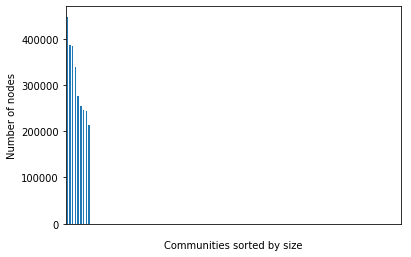

like


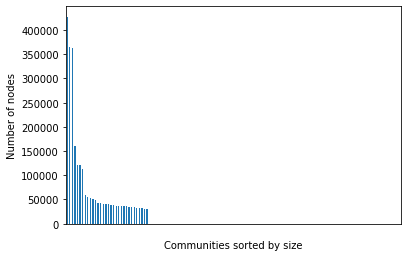

retweet


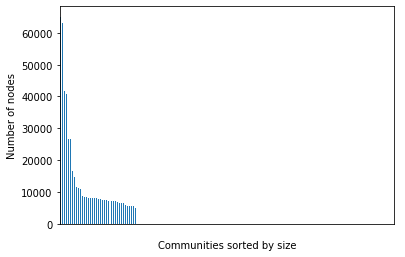

In [17]:
# Bar plot of the number of nodes in each community
for name, result in df_results.items():
    result.groupby('Community')["Id"].count().sort_values(ascending=False).plot(kind='bar')
    plt.xticks(color='w')
    plt.tick_params(bottom=False)
    plt.xlabel("Communities sorted by size", labelpad=-10)
    plt.ylabel("Number of nodes")
    plt.savefig(f"analysis/nodes_in_each_community_{name}.pdf", bbox_inches='tight')
    print(name)
    plt.show()

any


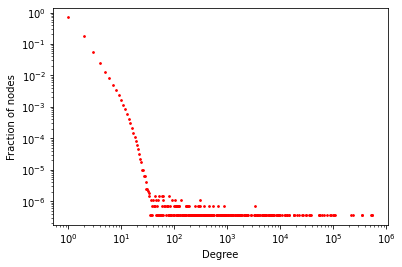

FileNotFoundError: [Errno 2] No such file or directory: 'analysis/gephistats_like.csv'

In [7]:
# Plot the degree distribution
for name, result in df_results.items():
    gephi_data = pd.read_csv(Path("analysis") / f"gephistats_{name}.csv")
    points = gephi_data.groupby('Degree')["Id"].count().sort_values(ascending=False).div(n['any']).to_frame().reset_index()
    points.plot(x='Degree', y='Id', kind='scatter', logx=True, logy=True, s=3, c='red')
    plt.xlabel("Degree")
    plt.ylabel("Fraction of nodes")
    plt.savefig(f"analysis/degree_distribution_{name}.pdf", bbox_inches='tight')
    print(name)
    plt.show()

### Take only the authors from the results

In [8]:
df_results_only_authors = {}
n_unique_only_authors = {}

for name, result in df_results.items():
    df_results_only_authors[name] = result[result['Is_author'] == True]
    n_unique_only_authors[name] = len(df_results_only_authors[name]['Id'].unique())
    print(f"Number of unique authors in {name} only authors: {n_unique_only_authors[name]}")

Number of unique authors in any only authors: 786
Number of unique authors in like only authors: 755
Number of unique authors in retweet only authors: 682


In [9]:
Path.mkdir(Path("analysis/authors"), exist_ok=True)
authors_info = {}

# create a list of all the authors and call the Twitter API
for name, result in df_results_only_authors.items():
    temp_result = result
    authors = list(result["Id"].unique())
    temp_df = pd.DataFrame()
    # split df by 100
    for i in range(0, len(authors), 100):
        print(f"{name}: Iteration {i}-{i+100} / {len(authors)}")
        df_100 = authors[i:i+100]
        res = client.get_users(ids=df_100, user_fields=["public_metrics", "verified"])
        for user_detail in res.data:
            temp_result.loc[temp_result['Id'] == user_detail['id'], 'Username'] = user_detail['username']
            temp_result.loc[temp_result['Id'] == user_detail['id'], 'Verified'] = user_detail['verified']
            temp_result.loc[temp_result['Id'] == user_detail['id'], 'followers_count'] = user_detail['public_metrics']['followers_count']
            temp_result.loc[temp_result['Id'] == user_detail['id'], 'following_count'] = user_detail['public_metrics']['following_count']
            temp_result.loc[temp_result['Id'] == user_detail['id'], 'tweet_count'] = user_detail['public_metrics']['tweet_count']
    temp_df = pd.concat(
        [temp_df, temp_result], ignore_index=True)
    temp_df.to_csv(f"analysis/authors/authors_{name}.csv")
    authors_info[name] = temp_df

any: Iteration 0-100 / 786


/tmp/ipykernel_4490/177052312.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_result.loc[temp_result['Id'] == user_detail['id'], 'Username'] = user_detail['username']
/tmp/ipykernel_4490/177052312.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_result.loc[temp_result['Id'] == user_detail['id'], 'Verified'] = user_detail['verified']
/tmp/ipykernel_4490/177052312.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

any: Iteration 100-200 / 786
any: Iteration 200-300 / 786
any: Iteration 300-400 / 786
any: Iteration 400-500 / 786
any: Iteration 500-600 / 786
any: Iteration 600-700 / 786
any: Iteration 700-800 / 786
like: Iteration 0-100 / 755


/tmp/ipykernel_4490/177052312.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_result.loc[temp_result['Id'] == user_detail['id'], 'Username'] = user_detail['username']
/tmp/ipykernel_4490/177052312.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_result.loc[temp_result['Id'] == user_detail['id'], 'Verified'] = user_detail['verified']
/tmp/ipykernel_4490/177052312.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

like: Iteration 100-200 / 755
like: Iteration 200-300 / 755
like: Iteration 300-400 / 755
like: Iteration 400-500 / 755
like: Iteration 500-600 / 755
like: Iteration 600-700 / 755
like: Iteration 700-800 / 755
retweet: Iteration 0-100 / 682


/tmp/ipykernel_4490/177052312.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_result.loc[temp_result['Id'] == user_detail['id'], 'Username'] = user_detail['username']
/tmp/ipykernel_4490/177052312.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_result.loc[temp_result['Id'] == user_detail['id'], 'Verified'] = user_detail['verified']
/tmp/ipykernel_4490/177052312.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

retweet: Iteration 100-200 / 682
retweet: Iteration 200-300 / 682
retweet: Iteration 300-400 / 682
retweet: Iteration 400-500 / 682
retweet: Iteration 500-600 / 682
retweet: Iteration 600-700 / 682


### Retrieve authors info for the two biggest communities

#### Any (likes + retweets)

In [10]:
authors_info['any'][authors_info['any']['Community'] == biggest_communities['any'][0]]

,Id,Community,Label,Is_author,Username,Verified,followers_count,following_count,tweet_count
30,300078224,567,300078224,True,MissMeryn,False,314.0,2990.0,7119.0
140,1164907412630827008,567,1164907412630827008,True,NaN,NaN,NaN,NaN,NaN
155,1341232362,567,1341232362,True,valuesearcher,False,218.0,96.0,5618.0
250,1340124668825657349,567,1340124668825657349,True,ARedbord,False,1063.0,494.0,619.0
266,1387847713065213954,567,1387847713065213954,True,masi82870170,False,557.0,1683.0,527.0
317,117213468,567,117213468,True,ArielFornari,False,2505.0,4510.0,194874.0
328,155627025,567,155627025,True,butterflySerend,False,138.0,238.0,15685.0
331,1175962189766643712,567,1175962189766643712,True,ThahirAmal,False,127.0,593.0,3020.0
362,2342054232,567,2342054232,True,KondratieffWave,False,2090.0,4638.0,30047.0
369,1281634934327828482,567,1281634934327828482,True,itayariel1,False,1793.0,726.0,9194.0


In [11]:
authors_info['any'][authors_info['any']['Community'] == biggest_communities['any'][1]]

,Id,Community,Label,Is_author,Username,Verified,followers_count,following_count,tweet_count
9,1461676508808978437,554,1461676508808978437,True,NaN,NaN,NaN,NaN,NaN
16,1405991133017169926,554,1405991133017169926,True,JoeSmols,False,993.0,246.0,15422.0
17,89437990,554,89437990,True,AimHigh_TV1,False,87757.0,6180.0,5958.0
34,393896089,554,393896089,True,olha2810,False,6.0,54.0,312.0
38,4188145335,554,4188145335,True,Sawomir86174818,False,622.0,1841.0,122231.0
41,12166972,554,12166972,True,niniwe,False,261.0,834.0,8865.0
49,729702644,554,729702644,True,BlueDotCitizen,False,6533.0,6574.0,78048.0
73,1456600599940710467,554,1456600599940710467,True,bijouaicha3,False,206.0,199.0,14094.0
74,1390351886704947200,554,1390351886704947200,True,stellarwp,False,1074.0,472.0,1073.0
95,2651414005,554,2651414005,True,Europa97531,False,1702.0,2345.0,47815.0


#### Likes

In [12]:
authors_info['like'][authors_info['like']['Community'] == biggest_communities['like'][0]]

,Id,Community,Label,Is_author,Username,Verified,followers_count,following_count,tweet_count
275,1044937263489134592,183,1044937263489134592,True,stefano688,False,701.0,4948.0,81903.0
283,26651370,183,26651370,True,FrancescoLugli,False,753.0,685.0,10190.0
292,764397613,183,764397613,True,ulrike_baumann,False,259.0,55.0,236.0
519,1341232362,183,1341232362,True,valuesearcher,False,218.0,96.0,5618.0
607,1429797346678874112,183,1429797346678874112,True,Lecca64035164,False,4.0,0.0,1349.0
647,1430307870982107140,183,1430307870982107140,True,CardanoNoodz,False,5937.0,4175.0,23623.0


In [13]:
authors_info['like'][authors_info['like']['Community'] == biggest_communities['like'][1]]

,Id,Community,Label,Is_author,Username,Verified,followers_count,following_count,tweet_count
41,12166972,597,12166972,True,niniwe,False,261.0,834.0,8865.0
72,1390351886704947200,597,1390351886704947200,True,stellarwp,False,1074.0,472.0,1073.0
458,2389823918,597,2389823918,True,AlAkBseth,False,3810.0,3391.0,431448.0


#### Retweet

In [14]:
authors_info['retweet'][authors_info['retweet']['Community'] == biggest_communities['retweet'][0]]

,Id,Community,Label,Is_author,Username,Verified,followers_count,following_count,tweet_count
174,1065202791621296128,614,1065202791621296128,True,urbanhaiti,False,333.0,186.0,5622.0
186,895966977407074304,614,895966977407074304,True,EastMojo,True,17498.0,625.0,40829.0
251,2342054232,614,2342054232,True,KondratieffWave,False,2090.0,4638.0,30047.0
440,1265133839258697728,614,1265133839258697728,True,RR52725843,False,110.0,21.0,7361.0
461,360164560,614,360164560,True,SyriaArchives,False,672.0,2651.0,4955.0
531,26651370,614,26651370,True,FrancescoLugli,False,753.0,685.0,10190.0
533,1496805133279277061,614,1496805133279277061,True,GC35786982,False,2.0,34.0,560.0
534,41014243,614,41014243,True,qvalemangusta,False,1774.0,1226.0,144737.0


In [15]:
authors_info['retweet'][authors_info['retweet']['Community'] == biggest_communities['retweet'][1]]

,Id,Community,Label,Is_author,Username,Verified,followers_count,following_count,tweet_count
116,1340124668825657349,467,1340124668825657349,True,ARedbord,False,1063.0,494.0,619.0
276,864504738691268609,467,864504738691268609,True,DocsPSCbasics,False,787.0,680.0,13788.0
312,1941753763,467,1941753763,True,Lainielah,False,3667.0,3385.0,20635.0
318,138898251,467,138898251,True,btkrth,False,1837.0,4980.0,404063.0
392,1333125538706296833,467,1333125538706296833,True,Gurmind69618903,False,1728.0,2405.0,20355.0


## Comparison between our implementation and the one from NetworkX

In [98]:
results = {}
for name, G in nx_graphs.items():
    print(f"Graph of {len(G.nodes)} nodes")
    
    start_net = perf_counter()
    louvain_nx = community.louvain_partitions(G)
    first = next(louvain_nx)
    stop_net = perf_counter()
    print(f"After first passage: {len(first)} communities")
    # second = next(louvain_nx)
    # print(f"After second passage: {len(second)} communities")
    # third = next(louvain_nx)
    # print(f"After third passage: {len(third)} communities")
    print(f"Time for NetworkX: {stop_net - start_net}")
    
    start_our = perf_counter()
    print(f"Louvain on {name}")
    data = louvain(G, 1)
    stop_our = perf_counter()
    print(f"Time for our implementation: {stop_our - start_our}")
    results[name] = data

Graph of 375247 nodes
After first passage: 100 communities
Time for NetworkX: 29.213629999999284
Louvain on edgelists_any_sample
Passage 1
Iteration 1


100%|██████████| 375247/375247 [00:14<00:00, 25661.33it/s]

Iteration 2



100%|██████████| 375247/375247 [00:11<00:00, 34082.38it/s]

Iteration 3



100%|██████████| 375247/375247 [00:11<00:00, 33998.23it/s]

Iteration 4



100%|██████████| 375247/375247 [00:10<00:00, 35020.22it/s]

Constructing new graph


There are 100 communities after passage 1
Time for our implementation: 66.32583280000017
Graph of 350872 nodes


KeyboardInterrupt: 